In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/test.csv')

**DATA CLEANING**

In [ ]:
train.head()

In [ ]:
train.info()

We will now look if there is any missing data

In [ ]:
null = train.isnull().sum()
null_df = pd.DataFrame(null, columns=['count'])
null_df[null_df['count']!=0]

In [ ]:
mean = train.isnull().mean()
mean_df = pd.DataFrame(mean, columns=['mean'])
mean_df[mean_df['mean']!=0]

Since the ratio of missing data of rez_esc(Years behind in schooling) and v18q1(No of tablets in household) are 0.82 and 0.76 respectively, we are going to drop those columns.
We will deal with v2a1(montly rent) later

In [ ]:
train.drop(columns=['v18q1', 'rez_esc'], inplace=True)
test.drop(columns=['v18q1', 'rez_esc'], inplace=True)

There are two more columns with 5 missing data. meaneduc and SBQmeaned

In [ ]:
train['meaneduc'].plot(kind='hist', bins=30)

As the plot is a fairly well guasian curve, we can use mean to fill up the remaining values

In [ ]:
train['meaneduc'].fillna(np.mean(train['meaneduc']), inplace=True)
test['meaneduc'].fillna(np.mean(test['meaneduc']), inplace=True)

In [ ]:
np.sqrt(train['SQBmeaned']).plot(kind='hist', bins=30)

Clearly the square root of SQBmeaned column gives us exactly the same plot as meaneduc plot. Thus we can remove this feature as it is repetative.

In [ ]:
train.drop(columns=['SQBmeaned'], inplace=True)
test.drop(columns=['SQBmeaned'], inplace=True)

In [ ]:
train['Target'].value_counts()

There is a difference between the target outcomes. Let us procced anyway, if the outcome is not upto mark, we may try oversampling the data.

**CLEANING FAMILY MEMBERS DATA**

We look if any features are repeating or similar to each other

In [ ]:
 train[train['tamviv']!=train['r4t3']].head()

Maybe the number of members living in the household(tamviv) should be more revelent than all persons in the household(r4t3). Let us just verify once

In [ ]:
corr1 = train.corr()
print(corr1['Target']['tamviv'])
print(corr1['Target']['r4t3'])

As expected tamviv is correlated more than r4t3(Though sligth difference). So let us remove r4t3 as well.

In [ ]:
 train[train['hhsize']!=train['tamhog']]

In [ ]:
 train[train['hogar_total']!=train['tamhog']]

Clearly hhsize and tamhog and hogar_total are same features. We will remove hhsize and tamhog features

Since every household has one head member and not only the Target feature but most of the independent features are common to one household. From here we only take the head of the household rows(parentesco1) and analyze them.

In [ ]:
train_select = train.loc[train['parentesco1'] == 1]
test_select = test.loc[test['parentesco1'] == 1]

In [ ]:
train_select.head()

In [ ]:
train_select.info()

**EXTRA FEATURES**

There are a few columns which are individual member specific. We do not wish to loose that data with the above code. Some of these columns are-
* disabled
* male
* female
* escolari(No of years of education)

We create 4 new features- 
1. mean_edu      : Average education of all family members
2. no.of.males   : Number of males in household
3. no.of.females : Number of females in household
4. disabled      : Number of disabled members in family

In [ ]:
disabled=[]
num_male=[]
num_female=[]
mean_edu=[]
for i in train_select['idhogar']:
    k = train[train['idhogar']== i]['dis'].sum()
    j = train[train['idhogar']== i]['male'].sum()
    p = train[train['idhogar']== i]['female'].sum()
    e = train[train['idhogar']== i]['escolari'].mean()
    disabled.append(k)
    num_male.append(j)
    num_female.append(p)
    mean_edu.append(e)

# For test data
disabledt=[]
num_malet=[]
num_femalet=[]
mean_edut=[]
for i in test_select['idhogar']:
    k = test[test['idhogar']== i]['dis'].sum()
    j = test[test['idhogar']== i]['male'].sum()
    p = test[test['idhogar']== i]['female'].sum()
    e = test[test['idhogar']== i]['escolari'].mean()
    disabledt.append(k)
    num_malet.append(j)
    num_femalet.append(p)
    mean_edut.append(e)
    

In [ ]:
train_select.loc[:,'mean_edu'] = mean_edu
train_select.loc[:,'no.of.males'] = num_male
train_select.loc[:,'no.of.females'] = num_female
train_select.loc[:,'diabled'] = disabled

test_select.loc[:,'mean_edu'] = mean_edut
test_select.loc[:,'no.of.males'] = num_malet
test_select.loc[:,'no.of.females'] = num_femalet
test_select.loc[:,'diabled'] = disabledt

Since we have calculated mean education of all members we remove meaneduc column as well. The edjefe/edjefa column indicates the education of the household head. But since we have taken only the rows containing the head member, the 'escolari' column indicates the same

Hence we remove the edjefe/edjefa column and keep the escolari column in place.


We notice that 'dependency' column has a few yes/no in them. According to the formula, yes corresponds with 1 and no with 0

In [ ]:
train_select['dependency'] = train_select['dependency'].replace('yes', '1')
train_select['dependency'] = train_select['dependency'].replace('no', '0')

test_select['dependency'] = test_select['dependency'].replace('yes', '1')
test_select['dependency'] = test_select['dependency'].replace('no', '0')

In [ ]:
train_select['dependency'] = train_select['dependency'].astype(float)
test_select['dependency'] = test_select['dependency'].astype(float)

**RENT FEATURE**

In [ ]:
rr = train_select['v2a1'].isnull().sum()
print('Number of null rows in montly rent column - {}'.format(rr))

There are 5 features to be taken into considertion before filling up the montly rent column
1. tipovivi1 =1 own and fully paid house
2. tipovivi2 =1 own,  paying in installments
3. tipovivi3 =1 rented
4. tipovivi4 =1 precarious
5. tipovivi5 =1 other(assigned,  borrowed)

For all the households which are owned and fully paid, the montly rent column can be set to zero.

We can consider paying in installments as monthly rent.

We will decide precarious and borrowed house rents according to the data distribution

For the next 5 code snippets we will analyze which montly rent columns are null with respect to tipovivi feature

In [ ]:
train_select[(train_select['tipovivi1']==1) ]['v2a1'].isnull().sum()

In [ ]:
train_select[(train_select['tipovivi2']==1) ]['v2a1'].isnull().sum()

In [ ]:
train_select[(train_select['tipovivi3']==1) ]['v2a1'].isnull().sum()

In [ ]:
train_select[(train_select['tipovivi4']==1) ]['v2a1'].isnull().sum()

In [ ]:
train_select[(train_select['tipovivi5']==1) ]['v2a1'].isnull().sum()

There are 1856 households which are owned and thus we will asign the v2a1(monthly rent) column as 0.
Since the rent distribution is higly skewed, we will use median of the data and assign that value to remaininig 300 values(tipovivi4 and tipovivi5)

In [ ]:
index = train_select.index
for i in index:
    if train_select['tipovivi1'][i]==1:
        train_select.loc[i, 'v2a1'] = 0

index2 = test_select.index
for i in index2:
    if test_select['tipovivi1'][i]==1:
        test_select.loc[i, 'v2a1'] = 0

In [ ]:
median = train_select[(train_select['tipovivi3']==1) | ((train_select['tipovivi2']==1)) ]['v2a1'].median()

mediant = test_select[(test_select['tipovivi3']==1) | ((test_select['tipovivi2']==1)) ]['v2a1'].median()

In [ ]:
for i in train_select.index:
    if train_select['tipovivi4'][i]==1:
        train_select.loc[i, 'v2a1'] = median
        
for i in train_select.index:
    if train_select['tipovivi5'][i]==1:
        train_select.loc[i, 'v2a1'] = median
        
for i in test_select.index:
    if test_select['tipovivi4'][i]==1:
        test_select.loc[i, 'v2a1'] = mediant
        
for i in test_select.index:
    if test_select['tipovivi5'][i]==1:
        test_select.loc[i, 'v2a1'] = mediant

In [ ]:
train_select['v2a1'].isnull().sum()

Graph below is a histogram plot of monthly rent

In [ ]:
train_select['v2a1'].plot(kind='hist', bins=30)

Below is the corelation array between Target and every other feature

In [ ]:
corr2 = train_select.corr()
corr2['Target']

Along with the features we remove as mentioned above, we also remove all the SQB columns as they are just the square root of other columns. We remove instlevel(education of a member), parentesco(relation as a family member), estadocivil(marriage data) as we are considering only household head data. 

In [ ]:
remove_columns=['tamhog', 'r4t3', 'r4h1','r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 
               'parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5','parentesco6',
                'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11',
               'parentesco12', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total','SQBhogar_nin',
                'SQBovercrowding', 'SQBdependency', 'agesq', 'edjefa','edjefe' ,'SQBedjefe', 'instlevel1', 
                'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5','instlevel6', 'instlevel7', 
                'instlevel8', 'instlevel9','meaneduc', 'hacdor', 'hacapo', 'estadocivil1', 'estadocivil2',
               'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'tipovivi1',
               'tipovivi2','tipovivi3','tipovivi4','tipovivi5', 'hhsize', 'dis', 'male', 'female']

In [ ]:
train_select_2 = train_select.drop(columns= remove_columns)
test_select_2 = test_select.drop(columns= remove_columns)

In [ ]:
train_select_2.head()

In [ ]:
X = train_select_2.drop(columns=['Target', 'idhogar', 'Id'])
y = train_select_2['Target']
X_given = test_select_2.drop(columns=[ 'idhogar', 'Id'])

**TRAINING THE MODEL**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

We will be using Random Forest Classifier algorithm. It is one of an ensamble technique and is also called as bootstrap aggregration. 

  We select random subsets of our data row and column wise. We feed these subsets to different decision trees simultaneously. The subsets which we create are always taken with replacement. Hence this technique is called **Row and Column Sampling with replacement**.
	
  Once the model is trained, we input the test data. Suppose we are classifying things, then the output that the majority of models give will be taken into account. Since we are first dividing then reassembling, this is called **Bootstrap aggregation**
  
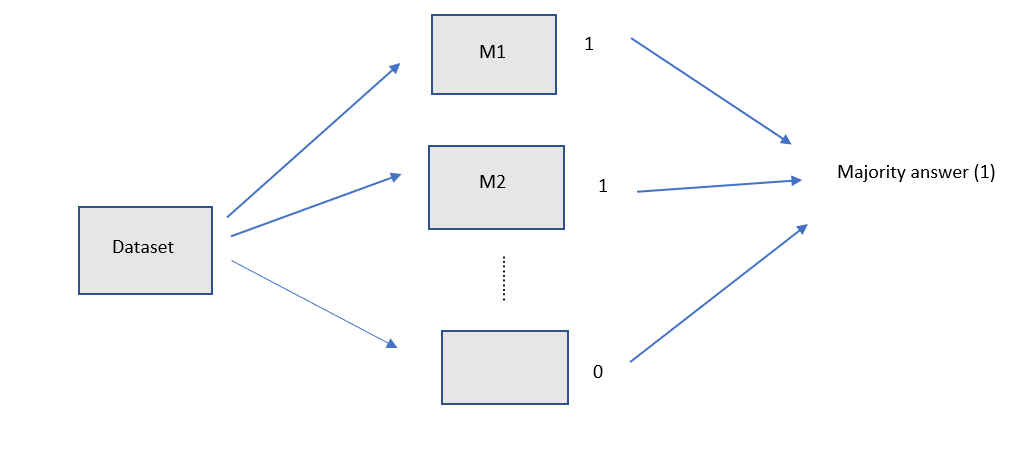


There are multiple hyperparameters when we use Random Forest. A few important ones are-
1. n_estimators    : Number of decision trees we want to use
2. max_depth       : Maximum depth of a decision tree. If None, then nodes are expanded till they are pure
3. max_features    : The maximum features to consider while spliting a node. 
4. min_sample_leaf : The minimum number of samples(row wise different examples) present at the leaf(end node).
5. min_sample_split: The minimum number of samples(row wise different examples) required to be present to split a node.

To know which hyperparameters are best, we implement Randomized Search CV. It randomly initializes the hyperparameters given in a dictionary and outputs the best parameters. Though it is faster than Grid Search CV, it still takes a lot of time for execution.

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
random_grid = {'n_estimators':[100, 200, 400, 600, 800],
              'max_depth' : [5, 10, 15,20, 30, None],
              'max_features' : ['auto', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split' : [2, 5, 10]} 

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, n_jobs = -1)

Another technique which we use is K-fold cross validation. Suppose we use 5 fold CV, it implies that the training data is divided into 5 parts. We take the first part as test and remaining 4 as train dataset. Then we take the second part as test and remaining as training sets. After complete process we take the average of all our scores. This will be the performance matrix of the model.

In [ ]:
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

In [ ]:
pred = rf_random.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(f1_score(y_test, pred, average='macro'))

After implementation of Randomized Search CV we came up with the following best parameters-
1. n_estimators    : 400
2. max_depth       : 30
3. max_features    : auto
4. min_sample_leaf : 1
5. min_sample_split: 2

To make the code more accurate, we will narrow our search down and use grid search cv which calculates accuracy for each and every combination.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = {'n_estimators':[ 470, 480, 490, 400, 510, 520, 530],
              'max_depth' : [25, 30,35, None],
              'max_features' : ['auto', 'log2'],
              'min_samples_leaf': [1, 2],
              'min_samples_split' : [ 2,3]}

In [ ]:
rf = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator = rf, param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
pred =grid_search.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(f1_score(y_test, pred, average='macro'))

The macro f1 score has sligtly increased. Accuracy is around 67%. We notice that class 4 has been predicted very well. But the other classes are not very accurate. This may be due to the fact that the training dataset had many many Target values belonging to class 4. Steps we can take to increase the accuracy-
1. Oversampling technique to avoid dominance of a single class
2. We can try to reduce the number of features furthermore 
3. We can use other algorithms such as Gradient boosting or Xg boost

We will now apply model to original test dataset and save our results to submission file.

In [ ]:
real_pred = grid_search.predict(X_given)

In [ ]:

c=0
for i in test_select['idhogar']:
    test2 = test[test['idhogar'] == i]
    for j in test2.index:
        test.loc[j, 'Target'] = real_pred[c] 
    c=c+1

In [ ]:
submit = pd.DataFrame({'Id': test['Id'], 'Target': test['Target']})

In [ ]:
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)